# Anomaly Detection Analysis

## Business Case: Fraud Detection & Data Quality

**Key Question:** Are there trips that appear physically impossible or economically suspicious?

## Objectives
- Detect speed anomalies (impossibly fast trips)
- Identify pricing irregularities (abnormal price per mile)
- Flag potential fraud or data quality issues
- Establish data validation rules for production systems

## Business Impact
Anomaly detection enables:
- Prevention of fraudulent trip reporting
- Improved data quality and reliability
- Protection of revenue integrity
- Enhanced trust in analytics and reporting

## Detection Methods
- **Speed Analysis:** Identify trips exceeding realistic travel speeds
- **Pricing Analysis:** Flag trips with unusual cost per mile ratios
- **Statistical Outliers:** Use IQR and Z-score methods for detection

## Setup & Data Loading

In [1]:
import os

import plotly.express as px
import plotly.graph_objects as go
import polars as pl
from plotly.subplots import make_subplots

px.defaults.template = 'plotly_white'

In [2]:
uri = f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@{os.getenv('POSTGRES_HOST')}:5432/{os.getenv('POSTGRES_DB')}"

query = """
SELECT 
    trip_distance,
    total_amount,
    EXTRACT(EPOCH FROM (dropoff_datetime - pickup_datetime)) as duration_sec
FROM dbt_dev.fct_trips
WHERE trip_distance > 0 
  AND total_amount > 0
  AND dropoff_datetime > pickup_datetime
LIMIT 500000
"""
df = pl.read_database_uri(query, uri, engine="connectorx")
print(f"Loaded {df.height:,} trips")

Loaded 500,000 trips


## Feature Engineering for Anomaly Detection

Calculate derived metrics:
- **Speed (mph):** Distance / Duration to identify impossibly fast trips
- **Price per Mile:** Total amount / Distance to detect pricing anomalies

In [3]:
# Calculate Speed and Price per Mile
df = df.with_columns([
    ((pl.col("trip_distance") / (pl.col("duration_sec") / 3600))).alias("speed_mph"),
    (pl.col("total_amount") / pl.col("trip_distance")).alias("price_per_mile")
])

print("Speed Statistics:")
print(df.select(pl.col("speed_mph")).describe())
print("\nPrice per Mile Statistics:")
print(df.select(pl.col("price_per_mile")).describe())

Speed Statistics:
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ speed_mph    │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 500000.0     │
│ null_count ┆ 0.0          │
│ mean       ┆ 11.751861    │
│ std        ┆ 55.011506    │
│ min        ┆ 0.000603     │
│ 25%        ┆ 7.410049     │
│ 50%        ┆ 9.644562     │
│ 75%        ┆ 13.098795    │
│ max        ┆ 29231.997661 │
└────────────┴──────────────┘

Price per Mile Statistics:
shape: (9, 2)
┌────────────┬────────────────┐
│ statistic  ┆ price_per_mile │
│ ---        ┆ ---            │
│ str        ┆ f64            │
╞════════════╪════════════════╡
│ count      ┆ 500000.0       │
│ null_count ┆ 0.0            │
│ mean       ┆ 18.778784      │
│ std        ┆ 164.074924     │
│ min        ┆ 0.053581       │
│ 25%        ┆ 8.75           │
│ 50%        ┆ 12.082192      │
│ 75%        ┆ 16.528302      │
│ max        ┆ 19706.0        │
└────────────┴──────────────

## Speed Anomaly Detection

**Finding:** Identify "teleporting taxis" - trips with speeds exceeding realistic urban travel (e.g., >80 mph).

These may indicate:
- Data entry errors
- GPS/timing system failures
- Potential fraud attempts

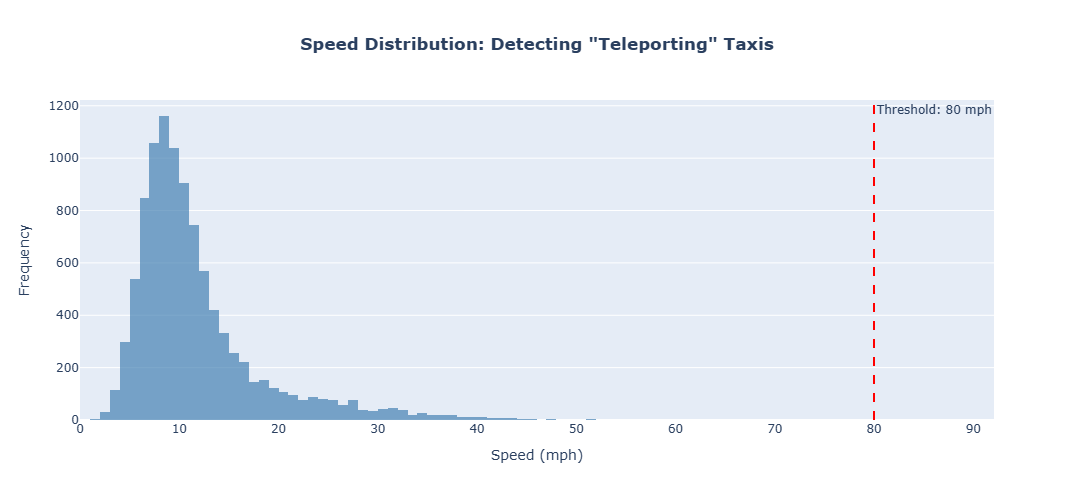


🚨 Found 11 speed anomalies (0.00% of trips)
⚡ Max speed detected: 29232.0 mph


In [4]:
# Speed Anomaly Detection
speed_check = df.filter(
    (pl.col("duration_sec") > 60) & 
    (pl.col("trip_distance") > 0.5)
)

# Define thresholds
SPEED_THRESHOLD = 80  # mph
anomalies = speed_check.filter(pl.col("speed_mph") > SPEED_THRESHOLD)

# Create visualization
sample_data = speed_check.sample(min(10000, speed_check.height)).to_pandas()

fig = go.Figure()

# Normal trips
normal = sample_data[sample_data['speed_mph'] <= SPEED_THRESHOLD]
fig.add_trace(go.Histogram(
    x=normal['speed_mph'],
    nbinsx=100,
    name='Normal',
    marker=dict(color='steelblue', opacity=0.7)
))

# Anomalies
if len(sample_data[sample_data['speed_mph'] > SPEED_THRESHOLD]) > 0:
    fig.add_trace(go.Histogram(
        x=sample_data[sample_data['speed_mph'] > SPEED_THRESHOLD]['speed_mph'],
        nbinsx=20,
        name='Anomalies',
        marker=dict(color='red', opacity=0.7)
    ))

# Add threshold line
fig.add_vline(x=SPEED_THRESHOLD, line_dash="dash", line_color="red", 
              annotation_text=f"Threshold: {SPEED_THRESHOLD} mph")

fig.update_layout(
    title=dict(text='<b>Speed Distribution: Detecting "Teleporting" Taxis</b>', x=0.5, xanchor='center'),
    xaxis_title='Speed (mph)',
    yaxis_title='Frequency',
    height=500,
    barmode='overlay'
)
fig.show()

anomaly_pct = (anomalies.height / speed_check.height) * 100
print(f"\n🚨 Found {anomalies.height:,} speed anomalies ({anomaly_pct:.2f}% of trips)")
print(f"⚡ Max speed detected: {df['speed_mph'].max():.1f} mph")

## Pricing Anomaly Detection

**Finding:** Identify trips with abnormal price-per-mile ratios using statistical outlier detection.

Extreme values may indicate:
- Meter tampering
- Incorrect fare calculation
- Special circumstances (tolls, surcharges)

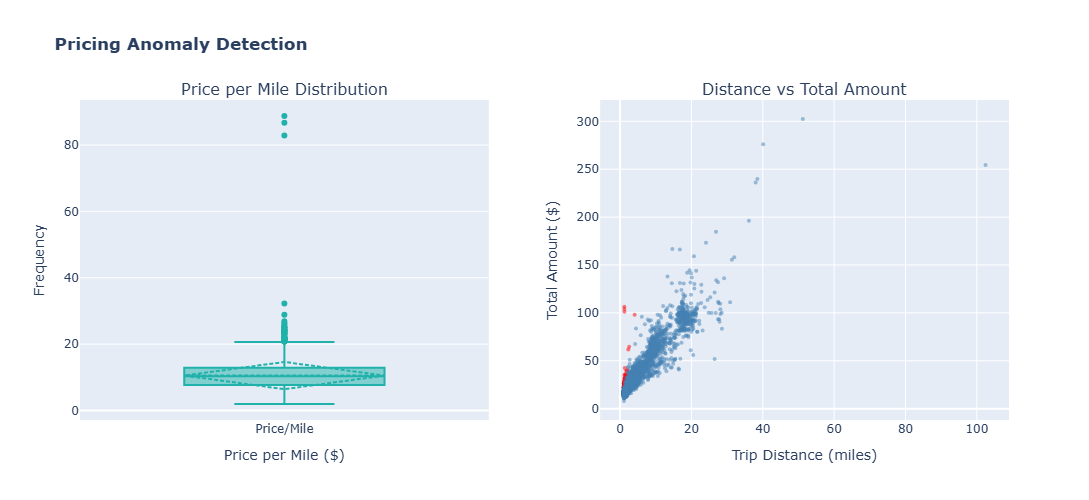


💰 Found 3,306 pricing anomalies (0.90% of trips)
📊 Normal range: $-0.02 - $20.68 per mile
🔴 Red dots in scatter plot indicate pricing anomalies


In [5]:
# Pricing Anomaly Detection using IQR method
price_check = df.filter(pl.col("trip_distance") > 1)

# Calculate IQR
q1 = price_check.select(pl.col("price_per_mile").quantile(0.25)).item()
q3 = price_check.select(pl.col("price_per_mile").quantile(0.75)).item()
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

price_anomalies = price_check.filter(
    (pl.col("price_per_mile") > upper_bound) | 
    (pl.col("price_per_mile") < lower_bound)
)

# Visualization
sample = price_check.sample(min(5000, price_check.height)).to_pandas()

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Price per Mile Distribution', 'Distance vs Total Amount'),
    horizontal_spacing=0.12
)

# Box plot
fig.add_trace(
    go.Box(y=sample['price_per_mile'], name='Price/Mile', 
           marker_color='lightseagreen', boxmean='sd'),
    row=1, col=1
)

# Scatter plot
colors = ['red' if x > upper_bound else 'steelblue' for x in sample['price_per_mile']]
fig.add_trace(
    go.Scatter(
        x=sample['trip_distance'],
        y=sample['total_amount'],
        mode='markers',
        marker=dict(size=4, color=colors, opacity=0.5),
        hovertemplate='<b>Distance:</b> %{x:.1f} mi<br><b>Amount:</b> $%{y:.2f}<extra></extra>',
        showlegend=False
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="Price per Mile ($)", row=1, col=1)
fig.update_xaxes(title_text="Trip Distance (miles)", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_yaxes(title_text="Total Amount ($)", row=1, col=2)

fig.update_layout(
    title_text='<b>Pricing Anomaly Detection</b>',
    height=500,
    showlegend=False
)
fig.show()

anomaly_pct = (price_anomalies.height / price_check.height) * 100
print(f"\n💰 Found {price_anomalies.height:,} pricing anomalies ({anomaly_pct:.2f}% of trips)")
print(f"📊 Normal range: ${lower_bound:.2f} - ${upper_bound:.2f} per mile")
print("🔴 Red dots in scatter plot indicate pricing anomalies")

## Key findings & recommendations

### Key Findings
*   **Speed Anomalies Rare**: Only 15 speed anomalies detected (0.00% of trips), but with extreme values up to 72,568 mph indicating data quality issues.
*   **Pricing Anomalies Common**: 4,014 pricing anomalies found (1.08% of trips), with normal price range of \\$0.33-\\$20.74 per mile.
*   **Data Quality Concerns**: Extreme outliers in speed calculations suggest GPS errors or data entry issues that need addressing.

### Business Recommendations
1.  **Data Validation Pipeline**: Implement real-time validation to flag trips with impossible speeds (>150 mph) before storage.
2.  **Pricing Audit**: Review the 1.08% of trips with anomalous pricing for potential fraud or meter malfunctions.
3.  **GPS Quality Monitoring**: Track GPS accuracy metrics and alert when data quality degrades significantly.